In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from ast import literal_eval
from itertools import chain
from collections import Counter
from pprint import pprint

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from nltk.corpus import stopwords

import spacy

# Tag classification

In [2]:
df = pd.read_csv('../data/raw/medium_starter_pack.csv', compression='gzip')
# Remove articles that have no tags (some are just comments)
df = df[df.tags != '[]']
# Remove null values in tag field
df = df.dropna(subset=['tags'])
# Transform df.tags into list (they are strings)
df.tags = df.tags.apply(literal_eval)
# Remove articles below upvote threshold
upvotes_threshold = 10
df = df[df.upvotes > upvotes_threshold]
# Reset index after all drops
df = df.reset_index(drop=True)
# Number of words in article body
df['n_words_body'] = df.body.apply(str.lower).apply(len)
# Remove articles with less than a certain number of words
words_body_threshold = 100
df = df[df.n_words_body > words_body_threshold]
df.shape

(4001, 14)

In [3]:
df.head()

,abstract,author_name,author_url,body,content_type,image_url,num_comments,publish_time,search_term,tags,title,upvotes,url,n_words_body
0,"While at university, I joined Shazam as part t...",Umar Hansa,https://medium.freecodecamp.org/@umaar,"While at university, I joined Shazam as part t...",article,https://cdn-images-1.medium.com/max/1200/1*ZQm...,9.0,2017-07-18T13:28:29.712Z,data visualisation,"[javascript, data visualization, startup, data...",Data Visualisation with 1 Billion Shazam Music...,975,https://medium.freecodecamp.org/data-visualisa...,6476
1,Since I dived into data visualisation I’ve lea...,Ana,https://hackernoon.com/@eyeofdata,Since I dived into data visualisation I’ve lea...,article,https://cdn-images-1.medium.com/max/1200/1*dBN...,4.0,2018-01-26T17:57:07.486Z,data visualisation,"[data visualization, data science, tech, techn...",What data visualisation has taught me so far –...,1300,https://hackernoon.com/what-data-visualisation...,5763
3,The trends of data visualisation are forever s...,Christian Thumer,https://medium.com/@christian_thumer,The trends of data visualisation are forever s...,article,https://cdn-images-1.medium.com/max/1200/0*Kxi...,4.0,2016-03-07T10:42:27.183Z,data visualisation,"[data visualization, data, trends]",Data visualisation: what’s next? – Signal Nois...,170,https://medium.com/signal-noise/data-visualisa...,12575
4,A boatload of visualisation tools and fancy da...,Ganes Kesari,https://towardsdatascience.com/@kesari,Inspite of the tremendous promise of data visu...,article,https://cdn-images-1.medium.com/max/1200/1*Mjs...,6.0,2018-05-03T02:36:08.697Z,data visualisation,"[data visualization, data science, design, inf...",6 Reasons why Data Visualisation projects Fail...,364,https://towardsdatascience.com/6-reasons-why-d...,8148
5,This is the third part of Twitter sentiment an...,The Rickest Ricky,https://towardsdatascience.com/@rickykim78,This is the third part of Twitter sentiment an...,article,https://cdn-images-1.medium.com/max/1200/1*Lfh...,2.0,2017-12-28T10:24:34.503Z,data visualisation,"[data science, nlp, zipfs law, bokeh, python]",Another Twitter sentiment analysis with Python...,415,https://towardsdatascience.com/another-twitter...,10670


## Clean up tags

Current list of 14 tags on [Pivigo's website](https://www.pivigo.com/dashboard/#/landing):
    - careers
    - case studies
    - visualisation
    - statistics
    - machine learning
    - nlp
    - ai/deep learning
    - general programming
    - python
    - r
    - intro to data science
    - data engineering
    - tools
    - ethics

In [4]:
# Transform list of lists into a list
def flatten(listOfLists):
    return list(chain.from_iterable(listOfLists))

class LazyDict(dict):
    # Update multiple keys from a list with the same value
    def keylist(self, keys, value):
        for key in keys:
            self[key] = value

# Tags to merge
tags_to_merge = LazyDict()
tags_to_merge.keylist(['ai', 'artificial intelligence', 'deep learning', 'neural networks'],
                           'ai/deep learning')
tags_to_merge.keylist(['tensorflow'],
                           ('ai/deep learning', 'tools'))
tags_to_merge.keylist(['chatbots', 'naturallanguageprocessing'],
                           'nlp')
tags_to_merge.keylist(['r programming'],
                           ('r', 'general programming'))
tags_to_merge.keylist(['python programming'],
                           ('python', 'general programming'))
tags_to_merge.keylist(['learning to code'],
                           ('general programming', 'intro to data science'))
tags_to_merge.keylist(['analytics', 'big data', 'data', 'data analysis', 'data science', 'towards data science'],
                           'machine learning')
tags_to_merge.keylist(['algorithms', 'coding', 'computer science', 'programming',
                       'software development', 'web development'],
                           'general programming')
tags_to_merge.keylist(['javascript', 'open source'],
                           ('general programming', 'tools'))
tags_to_merge.keylist(['bots', 'blockchain', 'database', 'sql', 'sql server'],
                           'tools')
tags_to_merge.keylist(['data visualization'],
                           'visualisation')
tags_to_merge.keylist(['startup', 'venture capital'],
                           'careers')
# Tags to remove: pre-specified list
tags_to_remove = ['design', 'education', 'politics', 'tech', 'technology', 'self driving cars']
# Build list with tags from all articles, and make dictionary with total counts for each tag
all_tags = flatten(df.tags)
all_tags_counts = Counter(all_tags)
# Tags to remove: tags appearing less than a certain number of times
threshold = 50
for tag, count in all_tags_counts.items():
    if count < threshold:
        tags_to_remove.append(tag)

# Assign filtered tags list back to DataFrame.
# Use set to remove eventual duplicates resulting from tag merging
def translate_tags(tags, tags_to_merge={}, tags_to_remove=[]):
    translated_tags = []
    for tag in tags:
        if tag not in tags_to_remove:
            merged_tags = tags_to_merge.get(tag, tag)
            # If it's a tuple, we want to un
            if isinstance(merged_tags, tuple):
                for merged_tag in merged_tags:
                    translated_tags.append(merged_tag)
            else:
                translated_tags.append(merged_tags)
    return list(sorted(set(translated_tags)))

#n_unique_tags = 
print('Number of unique tags (before filtering): ', len(set(all_tags)))

df.tags = [translate_tags(article_tags, tags_to_merge, tags_to_remove) for article_tags in list(df.tags)]

# Number of unique tags after filtering
all_filtered_tags = flatten(df.tags)
print('                       (after filtering): ', len(set(all_filtered_tags)))

# Get frequency of each filtered tag
print('\nTag counts after filtering:')
pprint(dict(Counter(all_filtered_tags)))

# Confirm filtered tags against reference list
correct_tags = ['careers', 'case studies', 'visualisation', 'statistics', 'machine learning', 'nlp',
                'ai/deep learning', 'general programming', 'python', 'r', 'intro to data science',
                'data engineering', 'tools', 'ethics']
print('\nRemaining tags not in reference list:')
pprint(dict(Counter([tag for tag in all_filtered_tags if tag not in correct_tags])))

print('\nReference list tags not in remaining tags:')
pprint([tag for tag in correct_tags if tag not in all_filtered_tags])

Number of unique tags (before filtering):  2334
                       (after filtering):  10

Tag counts after filtering:
{'ai/deep learning': 1963,
 'careers': 228,
 'general programming': 921,
 'machine learning': 2526,
 'nlp': 463,
 'python': 507,
 'r': 67,
 'statistics': 96,
 'tools': 650,
 'visualisation': 318}

Remaining tags not in reference list:
{}

Reference list tags not in remaining tags:
['case studies', 'intro to data science', 'data engineering', 'ethics']


In [5]:
# Split in train and test datasets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Create dummy variables for each tag, and transform test and train data accordingly
mlb = MultiLabelBinarizer()
mlb = mlb.fit(df.tags)
y_test = mlb.transform(test_data.tags)
y_train = mlb.transform(train_data.tags)

## Classification using TF-IDF

In [6]:
# Build the classification pipeline
text_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=300, stop_words='english')),
                     ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])

# Train the classifier
text_clf.fit(map(str, train_data['body'].values), y_train)

# Predict on test data
predicted = text_clf.predict(map(str, test_data['body'].values))

In [7]:
# Classification report: precision, recall and f1-score per class
print(classification_report(y_test, predicted, target_names=mlb.classes_))

                     precision    recall  f1-score   support

   ai/deep learning       0.86      0.91      0.88       381
            careers       0.80      0.09      0.17        43
general programming       0.81      0.28      0.42       181
   machine learning       0.84      0.88      0.86       486
                nlp       0.93      0.28      0.43        97
             python       0.85      0.34      0.49        96
                  r       0.00      0.00      0.00         8
         statistics       0.00      0.00      0.00        18
              tools       0.61      0.20      0.30       135
      visualisation       0.88      0.18      0.30        78

        avg / total       0.82      0.61      0.65      1523



Fraction of articles with all tags correctly predicted:  0.39076154806491886


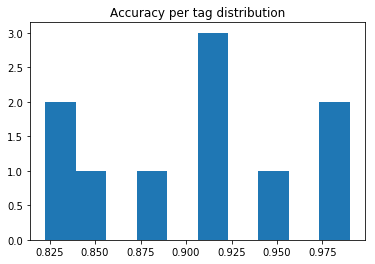

In [8]:
# Accuracy per tag
print('Fraction of articles with all tags correctly predicted: ', np.mean(np.all(predicted == y_test, axis=1)))
plt.title("Accuracy per tag distribution")
plt.hist(np.mean(predicted == y_test, axis=0));

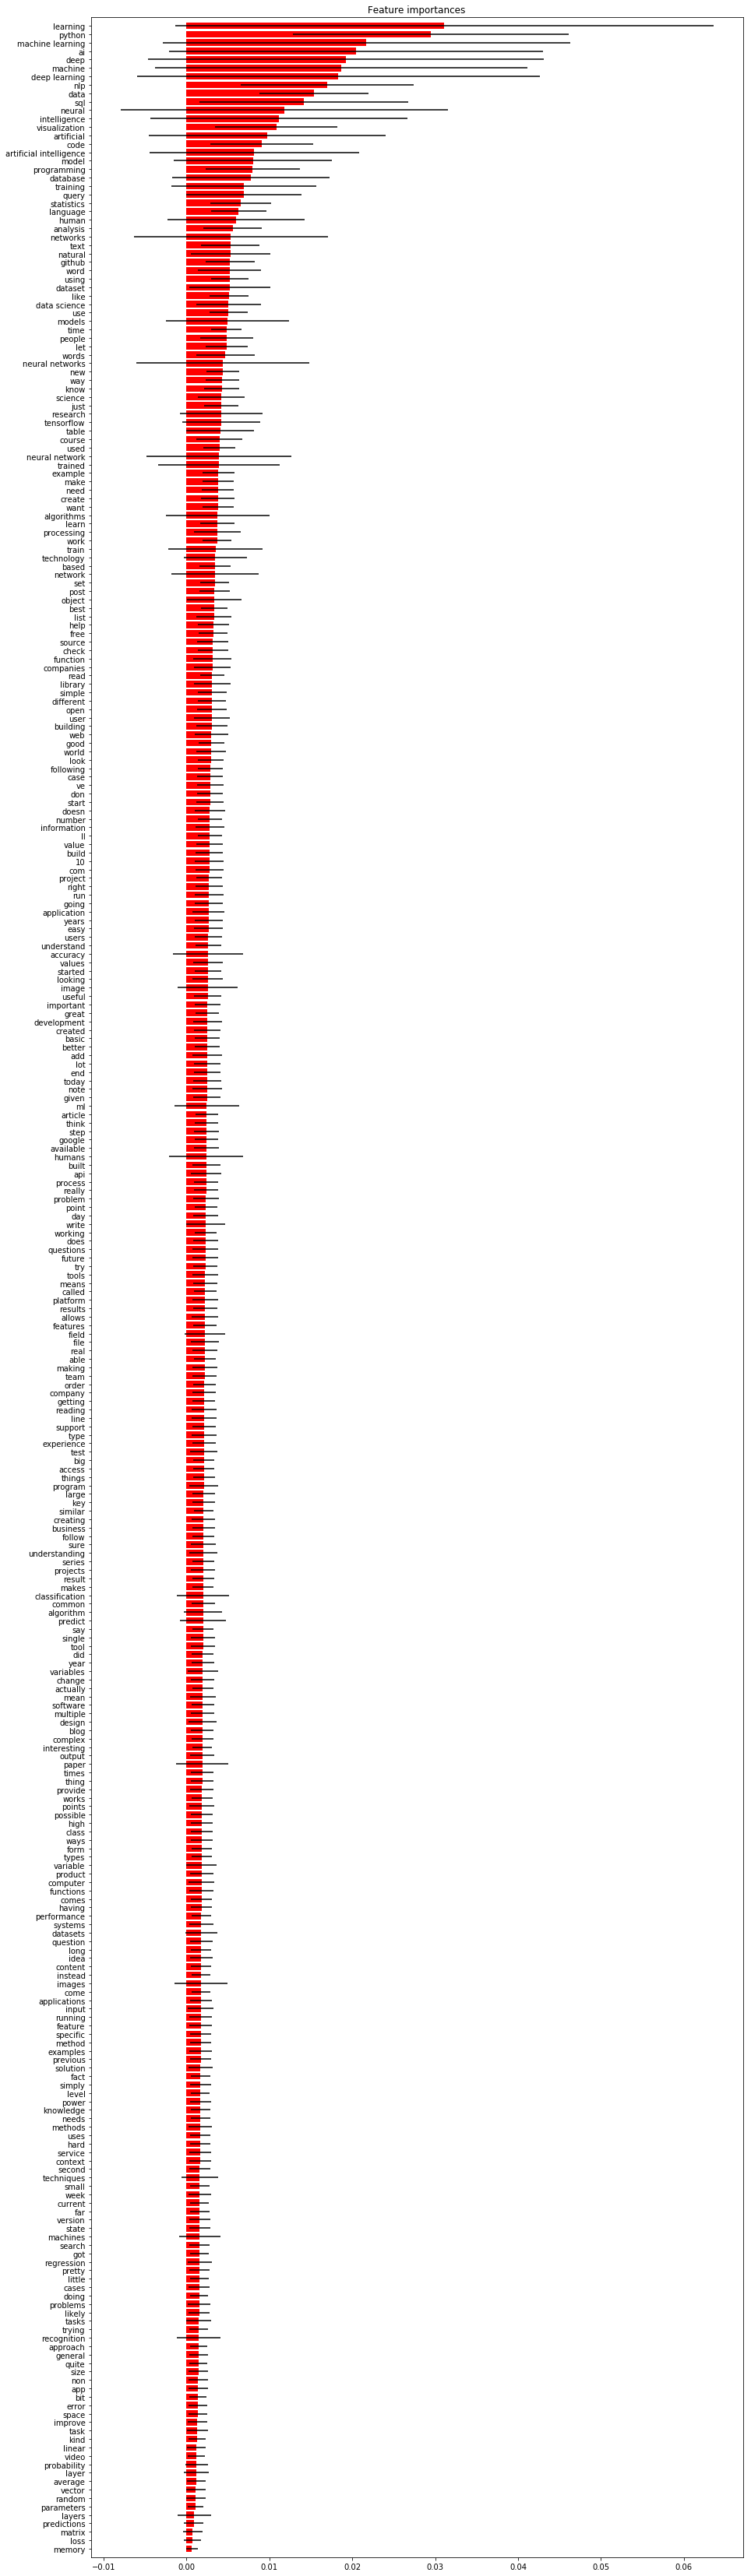

In [9]:
# Get tf-idf vectorizer and random forest classifier from pipeline
tfidf = text_clf.steps[0][1]
rf = text_clf.steps[1][1]
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(rf.feature_importances_)

# Plot the feature importances of the random forest
plt.figure(figsize=[15, 60])
plt.title("Feature importances")
plt.barh(range(len(rf.feature_importances_)), rf.feature_importances_[indices],
         color="r", xerr=std[indices], align="center")
# Use feature names as labels
plt.yticks(range(len(rf.feature_importances_)), [tfidf.get_feature_names()[i] for i in indices])
plt.ylim([-1, len(rf.feature_importances_)])
plt.show()

In [10]:
# Print some results (original vs predicted tags)
for i in range(30):
    print(i)
    print(test_data.iloc[i].url)
    print('Actual: ', test_data.iloc[i].tags)
    print('Predicted: ', mlb.inverse_transform(predicted)[i])

url_series = pd.Series(test_data.url).reset_index(drop=True)
test_tag_series = pd.Series(test_data.tags, name='test').reset_index(drop=True)
pred_tag_series = pd.Series(mlb.inverse_transform(predicted), name='pred').reset_index(drop=True)

pd.concat([url_series, test_tag_series, pred_tag_series], axis=1)

0
https://medium.com/@lachlanmiller_52885/machine-learning-week-1-cost-function-gradient-descent-and-univariate-linear-regression-8f5fe69815fd
Actual:  ['machine learning']
Predicted:  ('ai/deep learning', 'machine learning')
1
https://medium.com/@camrongodbout/creating-a-search-engine-f2f429cab33c
Actual:  ['general programming', 'machine learning', 'nlp']
Predicted:  ()
2
https://hackernoon.com/top-100-medium-writers-that-wrote-about-artificial-intelligence-machine-learning-deep-learning-c485dd5b8c6c
Actual:  ['ai/deep learning', 'machine learning', 'statistics']
Predicted:  ('ai/deep learning', 'machine learning')
3
https://medium.com/@anrao/hungry-3fe5300558be
Actual:  []
Predicted:  ()
4
https://medium.com/google-cloud/jwt-google-cloud-api-nlp-delphi-c9f6073e127b
Actual:  ['nlp']
Predicted:  ()
5
https://medium.com/@adsevenfour/vector-segmented-circles-tutorial-in-sketch-63ff9bdeaf92
Actual:  ['visualisation']
Predicted:  ()
6
https://medium.com/@mastepanoski/a-simple-approach-to-

,url,test,pred
0,https://medium.com/@lachlanmiller_52885/machin...,[machine learning],"(ai/deep learning, machine learning)"
1,https://medium.com/@camrongodbout/creating-a-s...,"[general programming, machine learning, nlp]",()
2,https://hackernoon.com/top-100-medium-writers-...,"[ai/deep learning, machine learning, statistics]","(ai/deep learning, machine learning)"
3,https://medium.com/@anrao/hungry-3fe5300558be,[],()
4,https://medium.com/google-cloud/jwt-google-clo...,[nlp],()
5,https://medium.com/@adsevenfour/vector-segment...,[visualisation],()
6,https://medium.com/@mastepanoski/a-simple-appr...,[],"(tools,)"
7,https://medium.com/@Infogram/5-jaw-dropping-bi...,"[machine learning, visualisation]",()
8,https://blog.usenotion.com/spreadsheets-are-no...,"[machine learning, visualisation]","(machine learning,)"
9,https://hajak.se/a-machine-learning-company-ne...,"[ai/deep learning, machine learning]","(ai/deep learning, machine learning)"


## Classification using Spacy's word embeddings

In [11]:
nlp = spacy.load("en_core_web_md", disable=['parser', 'tagger', 'ner'])

In [12]:
# Use English stopwords from nltk
en_stopwords = set(stopwords.words('english'))

# Compute average word vector for a document
def doc_vec(doc, stopwords):
    doc_nlp = nlp(doc)
    return np.average(np.array([w.vector for w in doc_nlp if w.text not in stopwords]), axis=0)

# Get average word vectors for each document
def build_doc_vecs(docs, stopwords):
    n_docs = len(docs)
    word_vector_shape = nlp.vocab.vectors.shape[-1]
    vectors = np.zeros([n_docs, word_vector_shape])
    for i, doc in tqdm(enumerate(docs)):
        vectors[i] = doc_vec(doc, stopwords)
    
    # in case we get any NaN's or Inf, replace them with 0s
    return np.nan_to_num(vectors)

In [13]:
X_train = build_doc_vecs(train_data.body.values, en_stopwords)
X_test = build_doc_vecs(test_data.body.values, en_stopwords)

print(X_train.shape)
print(X_test.shape)

3200it [00:29, 108.96it/s]
801it [00:06, 114.62it/s]

(3200, 300)
(801, 300)


In [14]:
# Build the classification pipeline
text_clf_vec = Pipeline([('classifier', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])

# Train the classifier
text_clf_vec.fit(X_train, y_train)

# Predict on test data
predicted_vec = text_clf_vec.predict(X_test)

In [15]:
# Classification report: precision, recall and f1-score per class
print(classification_report(y_test, predicted_vec, target_names=mlb.classes_))

                     precision    recall  f1-score   support

   ai/deep learning       0.83      0.83      0.83       381
            careers       1.00      0.05      0.09        43
general programming       0.78      0.28      0.41       181
   machine learning       0.79      0.90      0.84       486
                nlp       0.93      0.13      0.23        97
             python       0.89      0.17      0.28        96
                  r       0.00      0.00      0.00         8
         statistics       0.00      0.00      0.00        18
              tools       0.72      0.13      0.23       135
      visualisation       1.00      0.06      0.12        78

        avg / total       0.81      0.56      0.59      1523



Fraction of articles with all tags correctly predicted:  0.3383270911360799


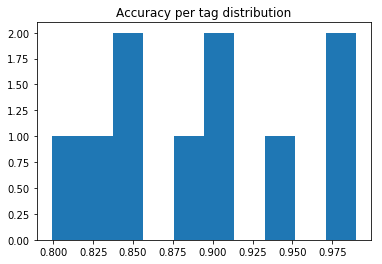

In [16]:
# Accuracy per tag
print('Fraction of articles with all tags correctly predicted: ', np.mean(np.all(predicted_vec == y_test, axis=1)))
plt.title("Accuracy per tag distribution")
plt.hist(np.mean(predicted_vec == y_test, axis=0));

In [17]:
# Print some results (original vs predicted tags)
for i in range(30):
    print(i)
    print(test_data.iloc[i].url)
    print('Actual: ', test_data.iloc[i].tags)
    print('Predicted: ', mlb.inverse_transform(predicted_vec)[i])

url_series = pd.Series(test_data.url).reset_index(drop=True)
test_tag_series = pd.Series(test_data.tags, name='test').reset_index(drop=True)
pred_tag_series = pd.Series(mlb.inverse_transform(predicted_vec), name='pred').reset_index(drop=True)

pd.concat([url_series, test_tag_series, pred_tag_series], axis=1)

0
https://medium.com/@lachlanmiller_52885/machine-learning-week-1-cost-function-gradient-descent-and-univariate-linear-regression-8f5fe69815fd
Actual:  ['machine learning']
Predicted:  ('machine learning',)
1
https://medium.com/@camrongodbout/creating-a-search-engine-f2f429cab33c
Actual:  ['general programming', 'machine learning', 'nlp']
Predicted:  ('machine learning',)
2
https://hackernoon.com/top-100-medium-writers-that-wrote-about-artificial-intelligence-machine-learning-deep-learning-c485dd5b8c6c
Actual:  ['ai/deep learning', 'machine learning', 'statistics']
Predicted:  ('machine learning',)
3
https://medium.com/@anrao/hungry-3fe5300558be
Actual:  []
Predicted:  ()
4
https://medium.com/google-cloud/jwt-google-cloud-api-nlp-delphi-c9f6073e127b
Actual:  ['nlp']
Predicted:  ()
5
https://medium.com/@adsevenfour/vector-segmented-circles-tutorial-in-sketch-63ff9bdeaf92
Actual:  ['visualisation']
Predicted:  ('machine learning',)
6
https://medium.com/@mastepanoski/a-simple-approach-to-

,url,test,pred
0,https://medium.com/@lachlanmiller_52885/machin...,[machine learning],"(machine learning,)"
1,https://medium.com/@camrongodbout/creating-a-s...,"[general programming, machine learning, nlp]","(machine learning,)"
2,https://hackernoon.com/top-100-medium-writers-...,"[ai/deep learning, machine learning, statistics]","(machine learning,)"
3,https://medium.com/@anrao/hungry-3fe5300558be,[],()
4,https://medium.com/google-cloud/jwt-google-clo...,[nlp],()
5,https://medium.com/@adsevenfour/vector-segment...,[visualisation],"(machine learning,)"
6,https://medium.com/@mastepanoski/a-simple-appr...,[],"(general programming, machine learning)"
7,https://medium.com/@Infogram/5-jaw-dropping-bi...,"[machine learning, visualisation]","(machine learning, visualisation)"
8,https://blog.usenotion.com/spreadsheets-are-no...,"[machine learning, visualisation]","(machine learning,)"
9,https://hajak.se/a-machine-learning-company-ne...,"[ai/deep learning, machine learning]","(machine learning,)"
